<a href="https://colab.research.google.com/github/ndb796/PyTorch-Object-Detection/blob/main/Mask_RCNN_with_ResNet_50_on_PASCAL_VOC_2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* <b>작성자</b>: 나동빈(dongbinna@postech.ac.kr)
* ResNet-50을 기반으로 하는 Mask RCNN 모델을 PASCAL VOC 2007을 이용해 학습합니다.
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.

#### <b>필요한 라이브러리 설치</b>

* <b>mmcv-full</b> 라이브러리를 설치해야 합니다.
* 약 15분가량의 시간이 소요됩니다.

In [ ]:
# 종속성 설치(Install Depenencies) (Colab이 CUDA 10.1 기반이므로 cu101 이용)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# CUDA 연산을 사용하기 위해 mmcv-full 라이브러리 설치
!pip install mmcv-full

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 4.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 245kB 14.5MB/s 
     |████████████████████████████████| 194kB 31.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.0-cp36-cp36m-linux_x86_64.whl size=17027959 sha256=04c7a130d2865ceed2713081cd5336901621cfe7a58e81ed5d11762fc0e3ccbc
  Stored in directory: /root/.cache/pip/wheels/b1/28/b7/e7efc5f0bfd71e6b8da29143406795dccd177fe94eba869cf4
Successfully built mmcv-full


In [ ]:
# MMDetection 라이브러리 설치 (Object Detection 목적)
!rm -rf mmdetection
!git clone https://github.com/ndb796/mmdetection # MMDetection에서 VOC 2007 학습 버전을 추가한 저장소
%cd mmdetection

# 필요한 라이브러리 설치
!pip install -e .

# Google Colab에서의 버그를 방지하기 위해 Pillow 7.0.0 구버전을 사용
!pip install Pillow==7.0.0

Cloning into 'mmdetection'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 14297 (delta 8), reused 0 (delta 0), pack-reused 14276
Receiving objects: 100% (14297/14297), 14.13 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (9726/9726), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


#### <b>라이브러리 정상 동작 확인</b>

* 가장 먼저 <b>사전 학습된(Pre-trained)</b> 모델을 다운로드하여 라이브러리 동작을 확인합니다.
* MMDetection이 공식 제공하는 COCO 사전 학습 모델을 사용할 수 있습니다.
* 사용한 모델: Mask RCNN ResNet-50 FPN 1x COCO

In [ ]:
!mkdir -p ./checkpoints
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdQ9qu6H5-FCgIh1Yk-FTqEBsqH8hVms4aFWbgYchdhQLA?download=1 -O ./checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth

--2020-11-18 14:01:09--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdQ9qu6H5-FCgIh1Yk-FTqEBsqH8hVms4aFWbgYchdhQLA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZFE5cXU2SDUtRkNnSWgxWWstRlRxRUJzcUg4aFZtczRhRldiZ1ljaGRoUUxBP3J0aW1lPVFMbGNaOHFMMkVn [following]
--2020-11-18 14:01:10--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nY

* <b>테스트</b>를 위해 한 장의 사진을 준비합니다.

In [ ]:
!wget https://image.freepik.com/free-photo/group-portrait-of-adorable-puppies_53876-64796.jpg -O test.jpg

--2020-11-18 14:01:26--  https://image.freepik.com/free-photo/group-portrait-of-adorable-puppies_53876-64796.jpg
Resolving image.freepik.com (image.freepik.com)... 23.46.55.166, 2600:1408:3000:287::30ec, 2600:1408:3000:29a::30ec
Connecting to image.freepik.com (image.freepik.com)|23.46.55.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61458 (60K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  60.02K  --.-KB/s    in 0.002s  

2020-11-18 14:01:26 (31.4 MB/s) - ‘test.jpg’ saved [61458/61458]



* <b>모델을 초기화</b>하여 이미지를 테스트합니다.

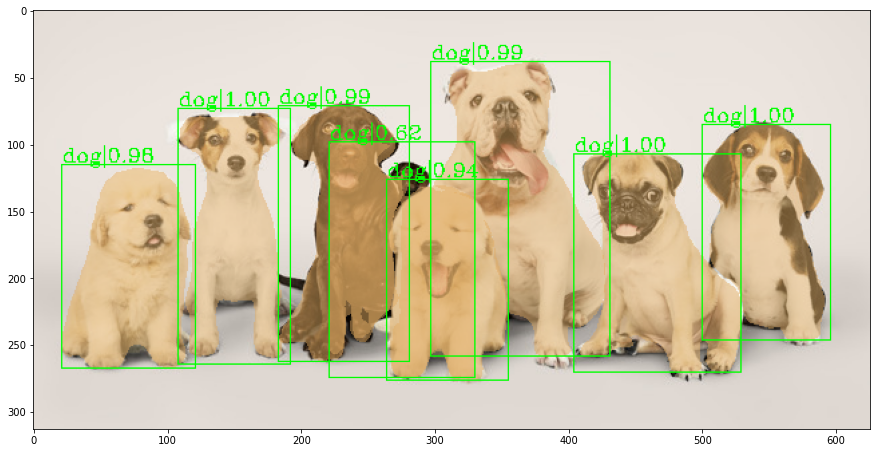

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

# 모델 환경 설정 파일과 체크포인트(Checkpoint) 파일 명시
config_file = './configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth' 

# 환경 설정 파일과 체크포인트 파일을 이용하여 모델 초기화
model = init_detector(config_file, checkpoint_file)

# 단순히 한 장의 이미지를 불러와 테스트
img = 'test.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

#### <b>VOC 2007로 모델을 학습하여 VOC 2007에서 평가하기</b>

* VOC 2007 데이터셋만을 이용해 학습 및 평가를 진행합니다.
* 원본 MMDetection에서는 VOC 2007과 VOC 2012을 이용해 학습을 진행하므로, 별도의 설정 파일이 필요합니다.
* 개인 저장소에 이 내용을 기록했습니다.
* 가장 먼저 <b>VOC 2007 데이터셋을 다운로드</b>합니다.

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYxPewFjc0dDre-A2xmtNn0B245hklQaByFZuUZDcjeGAQ?download=1 -O VOC2007Train.tar
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb_Zsk3K75pPmGXZkgG3-CIBzvCPIMNHZkVYGp2U-ePfXg?download=1 -O VOC2007Test.tar

--2020-11-18 14:01:40--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYxPewFjc0dDre-A2xmtNn0B245hklQaByFZuUZDcjeGAQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 40.108.156.33
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|40.108.156.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/VOCtrainval_06-Nov-2007.tar?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWXhQZXdGamMwZERyZS1BMnhtdE5uMEIyNDVoa2xRYUJ5Rlp1VVpEY2plR0FRP3J0aW1lPURweTNlY3FMMkVn [following]
--2020-11-18 14:01:41--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/VOCtrainval_06-Nov-2007.tar?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWXhQZXdGa

* <b>데이터셋 압축 파일의 압축을 해제</b>합니다.
* mmdetection의 <b>data 경로에 압축을 해제</b>해야 정상적으로 동작합니다.

In [ ]:
!mkdir -p ./data/
!tar -xvf VOC2007Train.tar -C ./data/
!tar -xvf VOC2007Test.tar -C ./data/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2007/JPEGImages/000725.jpg
VOCdevkit/VOC2007/JPEGImages/000727.jpg
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/000778.jpg
VOCd

* 학습을 진행합니다.

In [ ]:
# (Todo) 학습 코드를 작성해야 합니다.